**Dataset:** Telco Customer Churn (Kaggle Dataset)  
**Author:** Rishi Sheth  
**Professor:** Dr. Gautam Krishna  
**DOI / Citation:** Kaggle. “Telco Customer Churn.” Www.kaggle.com, 2017, www.kaggle.com/datasets/blastchar/telco-customer-churn.  
**Source:** https://www.kaggle.com/datasets/blastchar/telco-customer-churn

In [ ]:
# import & data loading
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import kagglehub

path = kagglehub.dataset_download("blastchar/telco-customer-churn")
df = pd.read_csv(os.path.join(path, "WA_Fn-UseC_-Telco-Customer-Churn.csv"))

Using Colab cache for faster access to the 'telco-customer-churn' dataset.


In [ ]:
# preprocessing
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(subset=['TotalCharges'], inplace=True)
if 'customerID' in df.columns:
    df.drop('customerID', axis=1, inplace=True)

# "No internet service" / "No phone service" to just "No"
cols_no_internet = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                    'TechSupport', 'StreamingTV', 'StreamingMovies']
df[cols_no_internet] = df[cols_no_internet].replace('No internet service', 'No')
df['MultipleLines'] = df['MultipleLines'].replace('No phone service', 'No')

# yes/no to 1/0
yes_no_cols = ['Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'OnlineSecurity',
               'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
               'StreamingMovies', 'PaperlessBilling', 'Churn']
for col in yes_no_cols:
    df[col] = df[col].replace({'Yes': 1, 'No': 0})

df['gender'] = df['gender'].replace({'Female': 1, 'Male': 0})

# one-hot encode rest
df = pd.get_dummies(df, columns=['InternetService', 'Contract', 'PaymentMethod'])

df_majority = df[df.Churn == 0]
df_minority = df[df.Churn == 1]
df_minority_upsampled = resample(df_minority,
                                 replace=True,
                                 n_samples=len(df_majority),
                                 random_state=42)

df_balanced = pd.concat([df_majority, df_minority_upsampled])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

X = df_balanced.drop('Churn', axis=1)
y = df_balanced['Churn']

print(df)


      gender  SeniorCitizen  Partner  Dependents  tenure  PhoneService  \
0          1              0        1           0       1             0   
1          0              0        0           0      34             1   
2          0              0        0           0       2             1   
3          0              0        0           0      45             0   
4          1              0        0           0       2             1   
...      ...            ...      ...         ...     ...           ...   
7038       0              0        1           1      24             1   
7039       1              0        1           1      72             1   
7040       1              0        1           1      11             0   
7041       0              1        1           0       4             1   
7042       0              0        0           0      66             1   

      MultipleLines  OnlineSecurity  OnlineBackup  DeviceProtection  ...  \
0                 0               0

/tmp/ipython-input-2431186115.py:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace({'Yes': 1, 'No': 0})
/tmp/ipython-input-2431186115.py:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['gender'] = df['gender'].replace({'Female': 1, 'Male': 0})


In [ ]:
print(y.value_counts(normalize=True))

Churn
0    0.5
1    0.5
Name: proportion, dtype: float64


In [ ]:
# train/val/test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# scaling
scaler = StandardScaler()
cont_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
X_train[cont_cols] = scaler.fit_transform(X_train[cont_cols])
X_val[cont_cols]   = scaler.transform(X_val[cont_cols])
X_test[cont_cols]  = scaler.transform(X_test[cont_cols])

# data to tensor
X_train_tensor = torch.tensor(X_train.values.astype(np.float32))
y_train_tensor = torch.tensor(y_train.values.astype(np.float32))
X_val_tensor   = torch.tensor(X_val.values.astype(np.float32))
y_val_tensor   = torch.tensor(y_val.values.astype(np.float32))
X_test_tensor  = torch.tensor(X_test.values.astype(np.float32))
y_test_tensor  = torch.tensor(y_test.values.astype(np.float32))

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val_tensor,   y_val_tensor),   batch_size=64)
test_loader  = DataLoader(TensorDataset(X_test_tensor,  y_test_tensor),  batch_size=64)

In [ ]:
# 3 layer MLP with dropout to strengthen learning
class ChurnNN(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc3(x))
        return x

model = ChurnNN(X_train.shape[1])
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

In [ ]:
# train loop
train_losses = []
val_losses   = []
train_accs   = []
val_accs     = []

print("Training started...")
for epoch in range(100):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X_batch.size(0)
        predicted = (outputs > 0.5).float()
        train_correct += (predicted == y_batch).sum().item()
        train_total += y_batch.size(0)

    train_loss /= len(train_loader.dataset)
    train_acc = train_correct / train_total

    train_losses.append(train_loss)
    train_accs.append(train_acc)

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)

            val_loss += loss.item() * X_batch.size(0)
            predicted = (outputs > 0.5).float()
            val_correct += (predicted == y_batch).sum().item()
            val_total += y_batch.size(0)

    val_loss /= len(val_loader.dataset)
    val_acc = val_correct / val_total

    val_losses.append(val_loss)
    val_accs.append(val_acc)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1:3d}/100] '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

Training started...
Epoch [ 10/100] Train Loss: 0.4898, Train Acc: 0.7678 | Val Loss: 0.4742, Val Acc: 0.7764
Epoch [ 20/100] Train Loss: 0.4765, Train Acc: 0.7785 | Val Loss: 0.4692, Val Acc: 0.7899
Epoch [ 30/100] Train Loss: 0.4677, Train Acc: 0.7817 | Val Loss: 0.4638, Val Acc: 0.7909
Epoch [ 40/100] Train Loss: 0.4614, Train Acc: 0.7889 | Val Loss: 0.4605, Val Acc: 0.7919
Epoch [ 50/100] Train Loss: 0.4582, Train Acc: 0.7889 | Val Loss: 0.4593, Val Acc: 0.7803
Epoch [ 60/100] Train Loss: 0.4480, Train Acc: 0.7964 | Val Loss: 0.4543, Val Acc: 0.7996
Epoch [ 70/100] Train Loss: 0.4462, Train Acc: 0.7936 | Val Loss: 0.4486, Val Acc: 0.8006
Epoch [ 80/100] Train Loss: 0.4428, Train Acc: 0.7979 | Val Loss: 0.4482, Val Acc: 0.7919
Epoch [ 90/100] Train Loss: 0.4384, Train Acc: 0.7996 | Val Loss: 0.4497, Val Acc: 0.7928
Epoch [100/100] Train Loss: 0.4317, Train Acc: 0.8016 | Val Loss: 0.4496, Val Acc: 0.7938



Results:
Accuracy : 0.7957
Precision: 0.7634
Recall   : 0.8566
F1 Score : 0.8073
AUC      : 0.8695
Test Loss: 0.4406


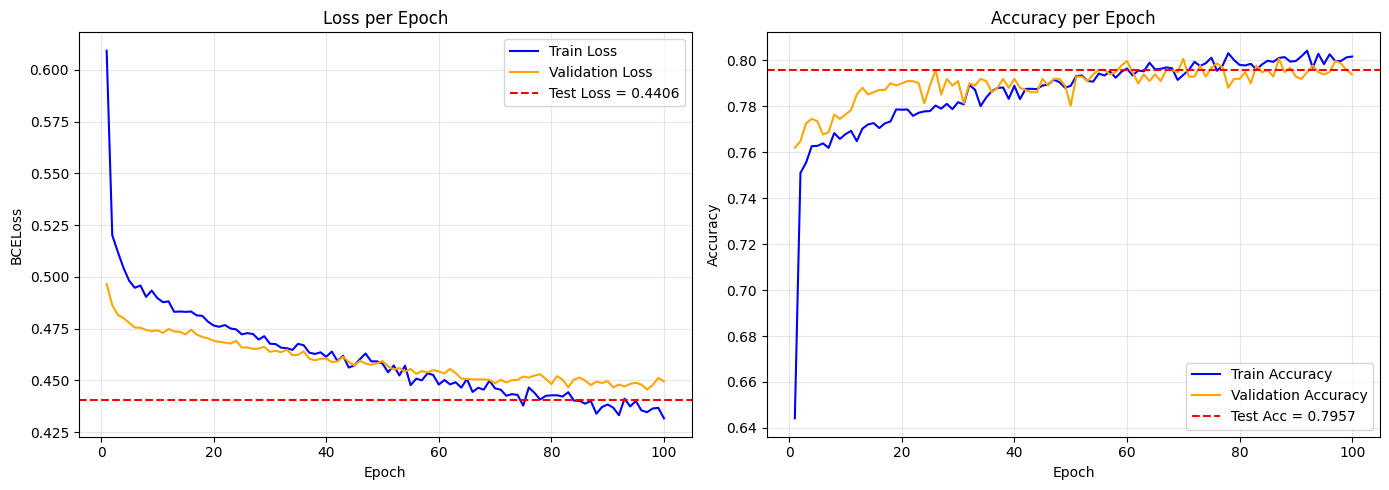

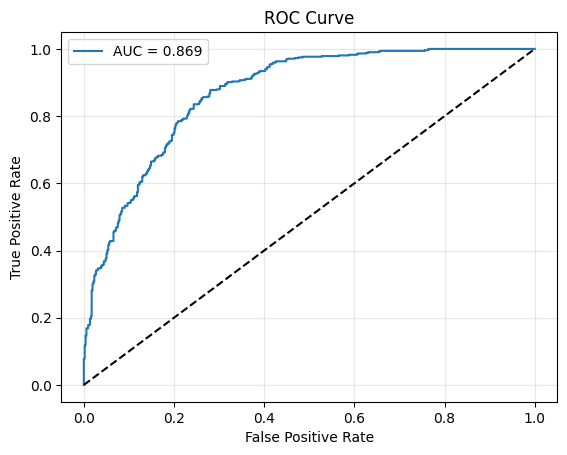

In [ ]:
# final model eval
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor).squeeze()
    test_preds = (test_outputs > 0.5).float()
    test_loss = criterion(test_outputs, y_test_tensor).item()
    y_prob = model(X_test_tensor).squeeze()
    y_prob_np = y_prob.cpu().numpy()
    y_pred = (y_prob > 0.5).float().cpu().numpy()
    test_loss = criterion(y_prob, y_test_tensor).item()

test_accuracy = accuracy_score(y_test, test_preds)
test_precision = precision_score(y_test, test_preds)
test_recall = recall_score(y_test, test_preds)
test_f1 = f1_score(y_test, test_preds)
fpr, tpr, thresholds = roc_curve(y_test, y_prob_np)
roc_auc = auc(fpr, tpr)


print(f'\nResults:')
print(f'Accuracy : {test_accuracy:.4f}')
print(f'Precision: {test_precision:.4f}')
print(f'Recall   : {test_recall:.4f}')
print(f'F1 Score : {test_f1:.4f}')
print(f"AUC      : {roc_auc:.4f}")
print(f'Test Loss: {test_loss:.4f}')

epochs = range(1, 101)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', color='blue')
plt.plot(epochs, val_losses,   label='Validation Loss', color='orange')
plt.axhline(y=test_loss, color='red', linestyle='--', label=f'Test Loss = {test_loss:.4f}')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('BCELoss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs, label='Train Accuracy', color='blue')
plt.plot(epochs, val_accs,   label='Validation Accuracy', color='orange')
plt.axhline(y=test_accuracy, color='red', linestyle='--', label=f'Test Acc = {test_accuracy:.4f}')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()